In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import csv

Instructions for updating:
non-resource variables are not supported in the long term


In [16]:
#dataset = pd.read_csv('X_trainData_1.csv')
#labels=pd.read_csv('Y_trainData_1.csv')
dataset = pd.read_csv('X_24hrs.csv')
datalabels = pd.read_csv('y_mumbai.csv')
#datalabels=pd.read_csv('2005-2008_yvalue_mumbai.csv')


#X_train=dataset.iloc[:,:].values

X=dataset.iloc[:,1:].values
y=datalabels.iloc[:,1:].values
#y_train=datalabels.iloc[:,-1].values
#y=datalabels.iloc[:,-1].values

In [17]:
print(X.shape)
print(X)

(2440, 9900)
[[300.87     292.05     276.39     ...  20.        28.75      35.25    ]
 [300.47     291.72     275.92     ...  28.25      70.250015  59.000015]
 [300.99     290.92     276.07     ...  26.75      65.500015  47.750015]
 ...
 [300.07498  290.55     275.35     ...  46.5       61.5       48.25    ]
 [300.14996  290.9      275.575    ...  47.25      62.        22.      ]
 [300.5      290.8      275.77496  ...  32.75      66.5       19.      ]]


In [18]:
print(y.shape)
print(y)

(2440, 1)
[[ 0.        ]
 [19.535807  ]
 [ 0.        ]
 ...
 [ 1.0364816 ]
 [ 0.18965113]
 [ 0.18965113]]


In [19]:
print(y.mean())
print(y.std())
mean_rf=y.mean()
std_rf=y.std()
thr=mean_rf+std_rf

18.48259008901639
29.95223440768119


In [20]:
count=0
for i in range(0, len(y)):

  if y[i]>thr:
    y[i]=1
    count=count+1
  else:
    y[i]=0
print(count)
print(y)

268
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]


In [21]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

X[:, :] = sc.fit_transform(X[:, :])

In [22]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

In [23]:
print(X.shape)
print(y.shape)

(4344, 9900)
(4344,)


In [24]:
all_data = X
#looking at the shape of the file
num_rows,num_cols= all_data.shape

# printing the array representation of one entry in csv file
print("the array of the first training input looks like", all_data[0])


# Deciding how many nodes wach layer should have
n_nodes_inpl = num_cols  #encoder
n_nodes_hl1  = 2500  #encoder
n_nodes_hl2  = 2500  #decoder
n_nodes_outl = num_cols  #decoder

# first hidden layer has 9900*2500 weights and 2500 biases
hidden_1_layer_vals = {
'weights':tf.Variable(tf.random.normal([n_nodes_inpl,n_nodes_hl1])),
'biases':tf.Variable(tf.random.normal([n_nodes_hl1]))  }
# second hidden layer has 2500*2500 weights and 2500 biases
hidden_2_layer_vals = {
'weights':tf.Variable(tf.random.normal([n_nodes_hl1, n_nodes_hl2])),
'biases':tf.Variable(tf.random.normal([n_nodes_hl2]))  }
# second hidden layer has 2500*9900 weights and 9900 biases
output_layer_vals = {
'weights':tf.Variable(tf.random.normal([n_nodes_hl2,n_nodes_outl])), 'biases':tf.Variable(tf.random.normal([n_nodes_outl])) }

# training sample goes in
input_layer = tf.placeholder('float', [None, num_cols])
# multiply output of input_layer wth a weight matrix and add biases
layer_1 = tf.nn.sigmoid(
       tf.add(tf.matmul(input_layer,hidden_1_layer_vals['weights']),
       hidden_1_layer_vals['biases']))
# multiply output of layer_1 wth a weight matrix and add biases
layer_2 = tf.nn.sigmoid(
       tf.add(tf.matmul(layer_1,hidden_2_layer_vals['weights']),
       hidden_2_layer_vals['biases']))
# multiply output of layer_2 wth a weight matrix and add biases
output_layer = tf.matmul(layer_2,output_layer_vals['weights']) +\
               output_layer_vals['biases']
# output_true shall have the original training sample for error calculations
output_true = tf.placeholder('float', [None, num_cols])
# define our cost function
meansq =    tf.reduce_mean(tf.square(output_layer - output_true))
# define our optimizer
learn_rate = 0.1   # how fast the model should learn
optimizer = tf.train.AdagradOptimizer(learn_rate).minimize(meansq)


# initialising stuff and starting the session
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
# defining batch size, number of epochs and learning rate
batch_size = 100  # how many samples to use together for training
hm_epochs = 1    # how many times to go through the entire dataset
tot_samples = 2440 # total number of samples

# total improvement is printed out after each epoch
for epoch in range(hm_epochs):
    epoch_loss = 0    # initializing error as 0
    for i in range(int(tot_samples/batch_size)):
        epoch_x = all_data[ i*batch_size : (i+1)*batch_size ]
        _, c = sess.run([optimizer, meansq],\
               feed_dict={input_layer: epoch_x, \
               output_true: epoch_x})
        epoch_loss += c
    print('Epoch', epoch, '/', hm_epochs-1, 'loss:',epoch_loss)

# running it though just the encoder
#df_comp = pd.DataFrame()
i=0
arr = np.empty((0,n_nodes_hl1), int)
for sample in all_data:
  encoded_sample = sess.run(layer_1,\
                   feed_dict={input_layer:[sample]})
  arr = np.append(arr, encoded_sample, axis=0)

# print the size of encoded data
print("size of encoded data set is:")  
print(arr.shape)
 
X=arr
    

the array of the first training input looks like [ 0.77220409  1.31421608  1.26477996 ... -1.02416529 -0.92323991
 -0.26355716]
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Epoch 0 / 0 loss: 12660.031219482422
size of encoded data set is:
(4344, 2500)


In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [26]:
from xgboost import XGBClassifier
#classifier = XGBClassifier(scale_pos_weight=20)
classifier = XGBClassifier()
classifier.fit(X_train, y_train.ravel())

XGBClassifier()

In [27]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)


[[383  42]
 [  6 438]]


In [28]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
print('Accuracy- '+str(accuracy_score(y_test, y_pred)))
print('Precision- '+str(precision_score(y_test,y_pred)))
print('Recall- '+str(recall_score(y_test, y_pred)))
print("ROC_AUC score- "+str(roc_auc_score(y_test, y_pred)))
print('F1-score- '+str(f1_score(y_test, y_pred)))

Accuracy- 0.9447640966628308
Precision- 0.9125
Recall- 0.9864864864864865
ROC_AUC score- 0.9438314785373608
F1-score- 0.948051948051948


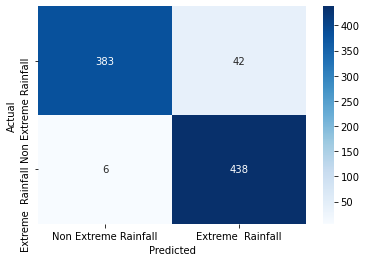

In [29]:
import seaborn as sn


df = pd.DataFrame(cm, index = ['Non Extreme Rainfall', 'Extreme  Rainfall'], columns = ['Non Extreme Rainfall', 'Extreme  Rainfall'])

# Plot the heatmap
sn.heatmap(df, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()